## Local Asymptotic Power Tests

Here I describe how the local asymptotic power test works on a t-test for the mean of normal data with known variance.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (14, 8)
sns.set_style("whitegrid")

### Theory

Suppose you have normal data $X_i \sim N(\mu, 1)$ for $i=1,\dots, n$ with known variance $\sigma = 1$ and unknown true mean parameter $\mu \in \mathbb{R}$. We want to test the hypothesis $H_0: \mu = \mu_0$ vs $H_1: \mu \neq \mu_0$ using a classic t-test. For this we construct the T-statistic
$$T = \sqrt{n} (\bar{X}_n - \mu_0) \,, $$
where $\bar{X}_n$ denotes the sample mean.

----

We are interested in the power function of this test. In this simple problem we can compute the true power function directly.

#### 1. (True) Finite Sample Power Function

Since everything is normal we have that $\bar{X}_n \sim N(\mu, 1 / n)$ and so

$$ T = \sqrt{n} (\bar{X}_n - \mu_0) \sim N(\sqrt{n}(\mu - \mu_0), 1) $$

but then the power function for a test with significance level $\alpha$ is simply computed as

\begin{align}
    \beta^n(\mu) &= P(|T| > c_\alpha)\\
    &=1 - \Phi(c_\alpha - \Delta) + \Phi(-c_\alpha - \Delta)
\end{align}

where $\Delta = \sqrt{n} (\mu - \mu_0)$.


#### 2. Asymptotic Approximation of the Power Function

Using the standard asymptotic arguments we see that

\begin{align}
    \beta^a(\mu) &= lim_{n \to \infty} P(|T| > c_\alpha)\\
    &= lim_{n \to \infty} P(|\sqrt{n} (\bar{X}_n - \mu_0)| > c_\alpha)\\
    &= lim_{n \to \infty} P(|\sqrt{n} (\bar{X}_n - \mu) + \sqrt{n} (\mu - \mu)| > c_\alpha)\\
    &=   \begin{cases}
            \alpha & \text{if } \mu = \mu_0 \\
            1& \text{else }
  \end{cases}
\end{align}


#### 3. Local Asymptotic Approximation of the Power Function

From the above it is already clear that the asymptotic approximation of the finite sample power function is very poor. So how can we improve the approximation quality even if we can only rely on asymptotic arguments?

The problem in the above case is that no matter how close the hypothesized value is to the true value, as $n$ approaches infinity any fixed distance is detectable with certainty. Say for the sake of the argument that we somehow let the distance between the hypothesized value and the true value decrease as $n$ increases. Now this can be modelled in various ways; here let us make the bold assumption that the data process changes with $n$ so that the *true* mean is given by $\mu_n := \mu_0 + c / \sqrt{n}$ for some localizing constant $c$ and some $\mu_0$ for which we will test. Again we will test $H_0: \mu_n = \mu_0$ vs. the alternative.

Let us now consider the T-statistic again; we have

$$ T = \sqrt{n} (\bar{X}_n - \mu_0) = \sqrt{n} (\bar{X}_n - \mu_n) + c$$

Now with some handwaving or a more rigorous framework we can show that the first part goes in distribution to a $N(0, 1)$ and as the second part is constant we have $T \to_d N(c, 1)$. Okay nice, but how does this help us in any way to construct a power function approximation. Remember how we defined the true value: $\mu_n := \mu_0 + c / \sqrt{n}$. Now drop the index $n$ and rearrange so that $c = \sqrt{n}(\mu - \mu_0)$. We therefore have that if $\mu$ is the true value and we test for $\mu_0$ the test statistic is distributed according to

$$ T \sim N(\sqrt{n}(\mu - \mu_0), 1) $$

but this is the exact distribution we had in the true finite sample case! So we see that in this case the local asymptotic approximation is much better. This might not always be the case.

----

For the actual computation below I will use the student t distribution in the finite case so that we will see at least a minor difference in the plots.

### Power function (approximations)

In [2]:
def finite_power_func(true_mean, hypothesized_mean, n_samples, size=0.05):
    """True finite power function of simple t-test of the mean.
    
    Here we can actually compute the true power function because I assume
    normal data.
    
    """
    crit_value = stats.t.ppf(1 - size / 2, df=n_samples - 1)
    delta = np.sqrt(n_samples) * (hypothesized_mean - true_mean)

    power = 1
    power -= stats.t.cdf(
        crit_value + delta,
        df=n_samples - 1,
    )
    power += stats.t.cdf(
        -crit_value + delta,
        df=n_samples - 1,
    )
    return power

In [3]:
def asymptotic_power_func(true_mean, hypothesized_mean, n_samples, size=.05):
    """Asymptotic power function of simple t-test of the mean."""
    power = np.ones(true_mean.shape)
    power[true_mean == hypothesized_mean] = size
    return power

In [4]:
def local_power_func(true_mean, hypothesized_mean, n_samples, size=0.05):
    """Power Function approximation using the local alternative approach."""
    crit_value = stats.norm.ppf(1 - size / 2)
    delta = np.sqrt(n_samples) * (hypothesized_mean - true_mean)

    power = 1
    power -= stats.norm.cdf(
        crit_value + delta
    )
    power += stats.norm.cdf(
        -crit_value + delta
    )

    return power

### Computation and Plotting

In [5]:
true = np.linspace(-1, 1, num=301)

hypothesis = 0
n_samples = 100
size = .05

In [6]:
df = pd.DataFrame(columns=["true", "asymptotic", "finite", "local"])

df["true"] = true
df["asymptotic"] = asymptotic_power_func(true, hypothesis, n_samples, size)
df["finite"] = finite_power_func(true, hypothesis, n_samples, size)
df["local"] = local_power_func(true, hypothesis, n_samples, size)

df = df.melt(id_vars="true", var_name="type", value_name="power")

***We see that the asymptotic power function gives a horrible approximation of the finite sample power function, while the local asymptotic power function is nearly equal to the finite sample version.***

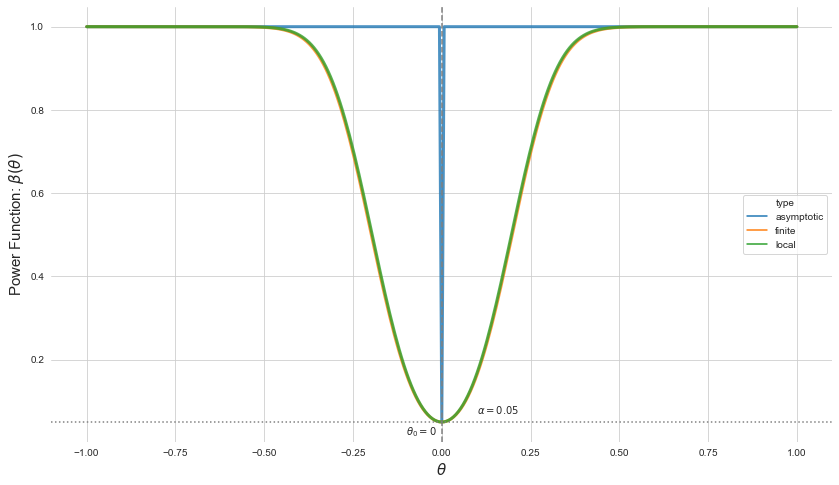

In [7]:
fig, ax = plt.subplots(1)

sns.lineplot(x="true", y="power", hue="type", data=df, linewidth=3, alpha=.8)

ax.axvline(0, ls="--", color="grey")
ax.text(-0.1, 0.02, r"$\theta_0 = 0$")
ax.axhline(0.05, ls=":", color="grey")
ax.text(0.1, 0.07, r"$\alpha=0.05$")

ax.set(ylabel=r"Power Function: $\beta(\theta)$", xlabel=r"$\theta$")
ax.set_frame_on(False)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)